In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import KFold

import statsmodels.api as sm
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

import optuna

warnings.filterwarnings('ignore')
pd.set_option("display.max_column", 999)

# Data Preparation/FE

In [2]:
DATA_PATH = './march-machine-learning-mania-2023/'
tourney_results = pd.concat([pd.read_csv(DATA_PATH + "MNCAATourneyDetailedResults.csv"),pd.read_csv(DATA_PATH + "WNCAATourneyDetailedResults.csv")],ignore_index=True)
seeds = pd.concat([pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv"),pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv")],ignore_index=True)
regular_results = pd.concat([pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv"),pd.read_csv(DATA_PATH + "WRegularSeasonDetailedResults.csv")],ignore_index=True)

def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
                 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]
    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]
    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    return output

regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean]
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head()

season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data.head()

tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

season_statistics_2 = regular_data.copy()
season_statistics_2["T1_POS"] = (season_statistics_2["T1_FGA"]-season_statistics_2["T1_OR"])+season_statistics_2["T1_TO"]+0.5*season_statistics_2["T1_FTA"]
season_statistics_2["T2_POS"] = (season_statistics_2["T2_FGA"]-season_statistics_2["T2_OR"])+season_statistics_2["T2_TO"]+0.5*season_statistics_2["T2_FTA"]
season_statistics_2["T1_PPP"] = season_statistics_2["T1_Score"]/season_statistics_2["T1_POS"]
season_statistics_2["T2_PPP"] = season_statistics_2["T2_Score"]/season_statistics_2["T2_POS"]

boxscore_cols = ["T1_POS","T2_POS","T1_PPP","T2_PPP"]
funcs = [np.mean]
season_statistics_2 = season_statistics_2.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics_2.columns = [''.join(col).strip() for col in season_statistics_2.columns.values]
season_statistics_2.head()

season_statistics_2['PPPMarg'] = season_statistics_2['T1_PPPmean'] - season_statistics_2['T2_PPPmean']

season_statistics_2_T1 = season_statistics_2.copy()
season_statistics_2_T2 = season_statistics_2.copy()

season_statistics_2_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_2_T1.columns)]
season_statistics_2_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_2_T2.columns)]
season_statistics_2_T1.columns.values[0] = "Season"
season_statistics_2_T2.columns.values[0] = "Season"

tourney_data = pd.merge(tourney_data, season_statistics_2_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_2_T2, on = ['Season', 'T2_TeamID'], how = 'left')

last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0) #**********
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)

march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

glm_quality = pd.concat([team_quality(2010),team_quality(2011),team_quality(2012),team_quality(2013),team_quality(2014),team_quality(2015),
                         team_quality(2016),team_quality(2017),team_quality(2018),team_quality(2019),team_quality(2021),team_quality(2022),team_quality(2023)]).reset_index(drop=True)

glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]
features = list(season_statistics_T1.columns[2:999])+list(season_statistics_T2.columns[2:999])+list(season_statistics_2_T1.columns[2:999])+\
    list(season_statistics_2_T2.columns[2:999])+list(seeds_T1.columns[2:999])+list(seeds_T2.columns[2:999])+list(last14days_stats_T1.columns[2:999])+\
    list(last14days_stats_T2.columns[2:999])

len(features)
features


KeyboardInterrupt: 

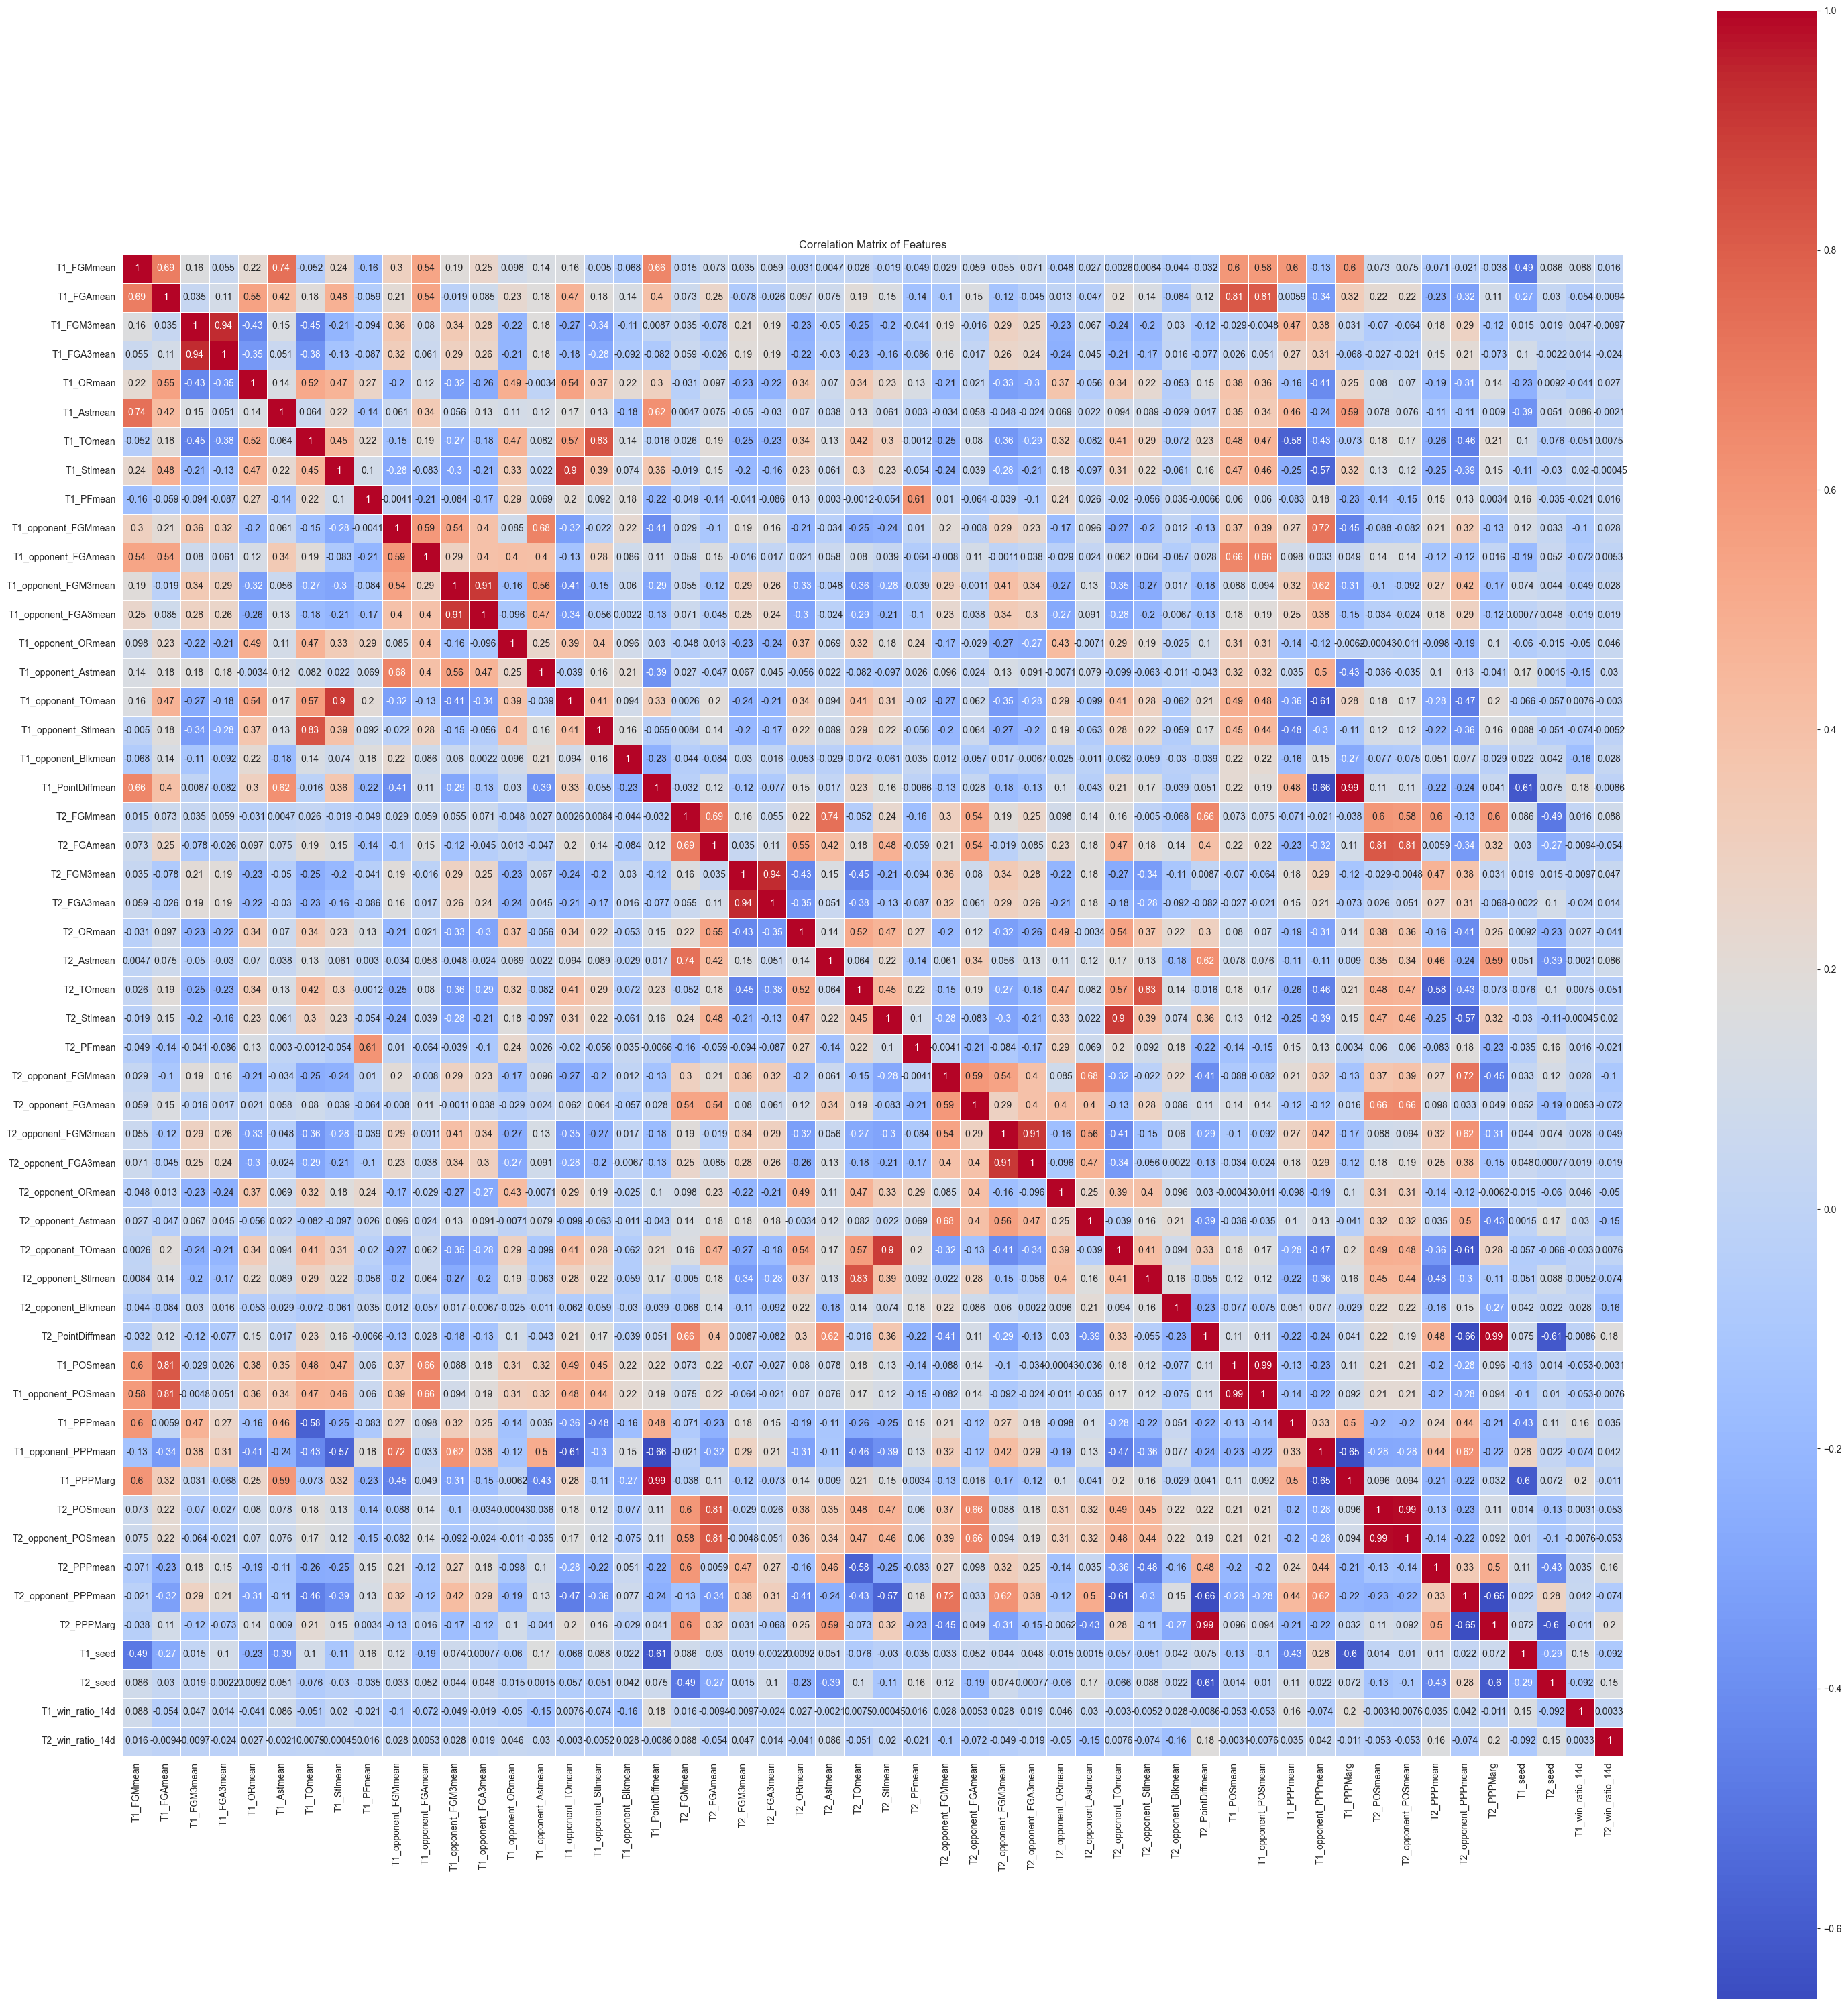

In [30]:
corr_matrix = tourney_data[features].corr()

# Generate a heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, linewidths=.5)
plt.title('Correlation Matrix of Features')
plt.tight_layout()
plt.savefig('./plot.png')
plt.show()


# Modeling

In [31]:
X = tourney_data[features].apply(lambda x: x.replace([np.inf,-np.inf],-999)).fillna(-999)
features_lr = [feat for feat in features if feat not in ['Seed_diff','T1_quality','T2_quality']]
X = X[features_lr].apply(lambda x: x.replace([np.inf,-np.inf],-999)).fillna(-999)

feat_cols = X.columns
X = X.values
y = (tourney_data['T1_Score']>tourney_data['T2_Score']).astype(int)

repeat_cv = 20

In [32]:
def train_lgbm_classifier(trial, X, y):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000, step = 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log = True),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "num_leaves": trial.suggest_int("num_leaves", 10, 100, step = 10),
        "subsample": trial.suggest_float("subsample", 0.5, 0.9,step = 0.1),
        "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.5, 0.9,step = 0.1),
        "random_state": 42,
        "objective": "binary"
    }
    lgbm_classifier = LGBMClassifier(**params)
    return lgbm_classifier

In [33]:
def objective(trial, X, y):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    brier_scores = []

    for train_idx, valid_idx in kfold.split(X):
        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        lgbm_classifier = train_lgbm_classifier(trial, X_train, y_train)
        lgbm_classifier.fit(X_train, y_train)

        y_pred = lgbm_classifier.predict_proba(X_valid)[:, 1]
        brier_score = brier_score_loss(y_valid, y_pred)
        brier_scores.append(brier_score)

    return np.mean(brier_scores)

study = optuna.create_study(direction="minimize")

[I 2023-04-16 16:17:35,149] A new study created in memory with name: no-name-45487c26-4715-42dc-be4d-e8eda42b6535


In [34]:
# %%time
# # Start optimizing with 50 trials
# study.optimize(lambda trial: objective(trial, X, y), n_trials=100)
# best_params = study.best_params
# print("Best parameters found:", best_params)

LGBM

20
Fold repeater 0
brier_score_loss of cvsplit 0: 0.1758399661937302
Fold repeater 1
brier_score_loss of cvsplit 1: 0.17566532721127393
Fold repeater 2
brier_score_loss of cvsplit 2: 0.1765028217581784
Fold repeater 3
brier_score_loss of cvsplit 3: 0.17491825965447594
Fold repeater 4
brier_score_loss of cvsplit 4: 0.1774656766587983
Fold repeater 5
brier_score_loss of cvsplit 5: 0.17568126482234658
Fold repeater 6
brier_score_loss of cvsplit 6: 0.1757830730736455
Fold repeater 7
brier_score_loss of cvsplit 7: 0.17567031093701943
Fold repeater 8
brier_score_loss of cvsplit 8: 0.1760573047990376
Fold repeater 9
brier_score_loss of cvsplit 9: 0.1760445741974485
Fold repeater 10
brier_score_loss of cvsplit 10: 0.1755849459913465
Fold repeater 11
brier_score_loss of cvsplit 11: 0.17611616022300708
Fold repeater 12
brier_score_loss of cvsplit 12: 0.17719777379728613
Fold repeater 13
brier_score_loss of cvsplit 13: 0.17640494972576148
Fold repeater 14
brier_score_loss of cvsplit 14: 0.1755905

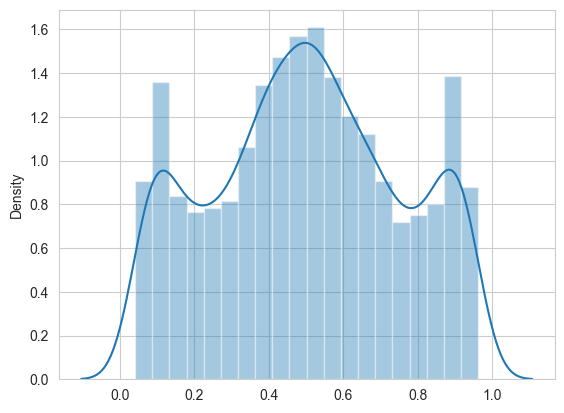

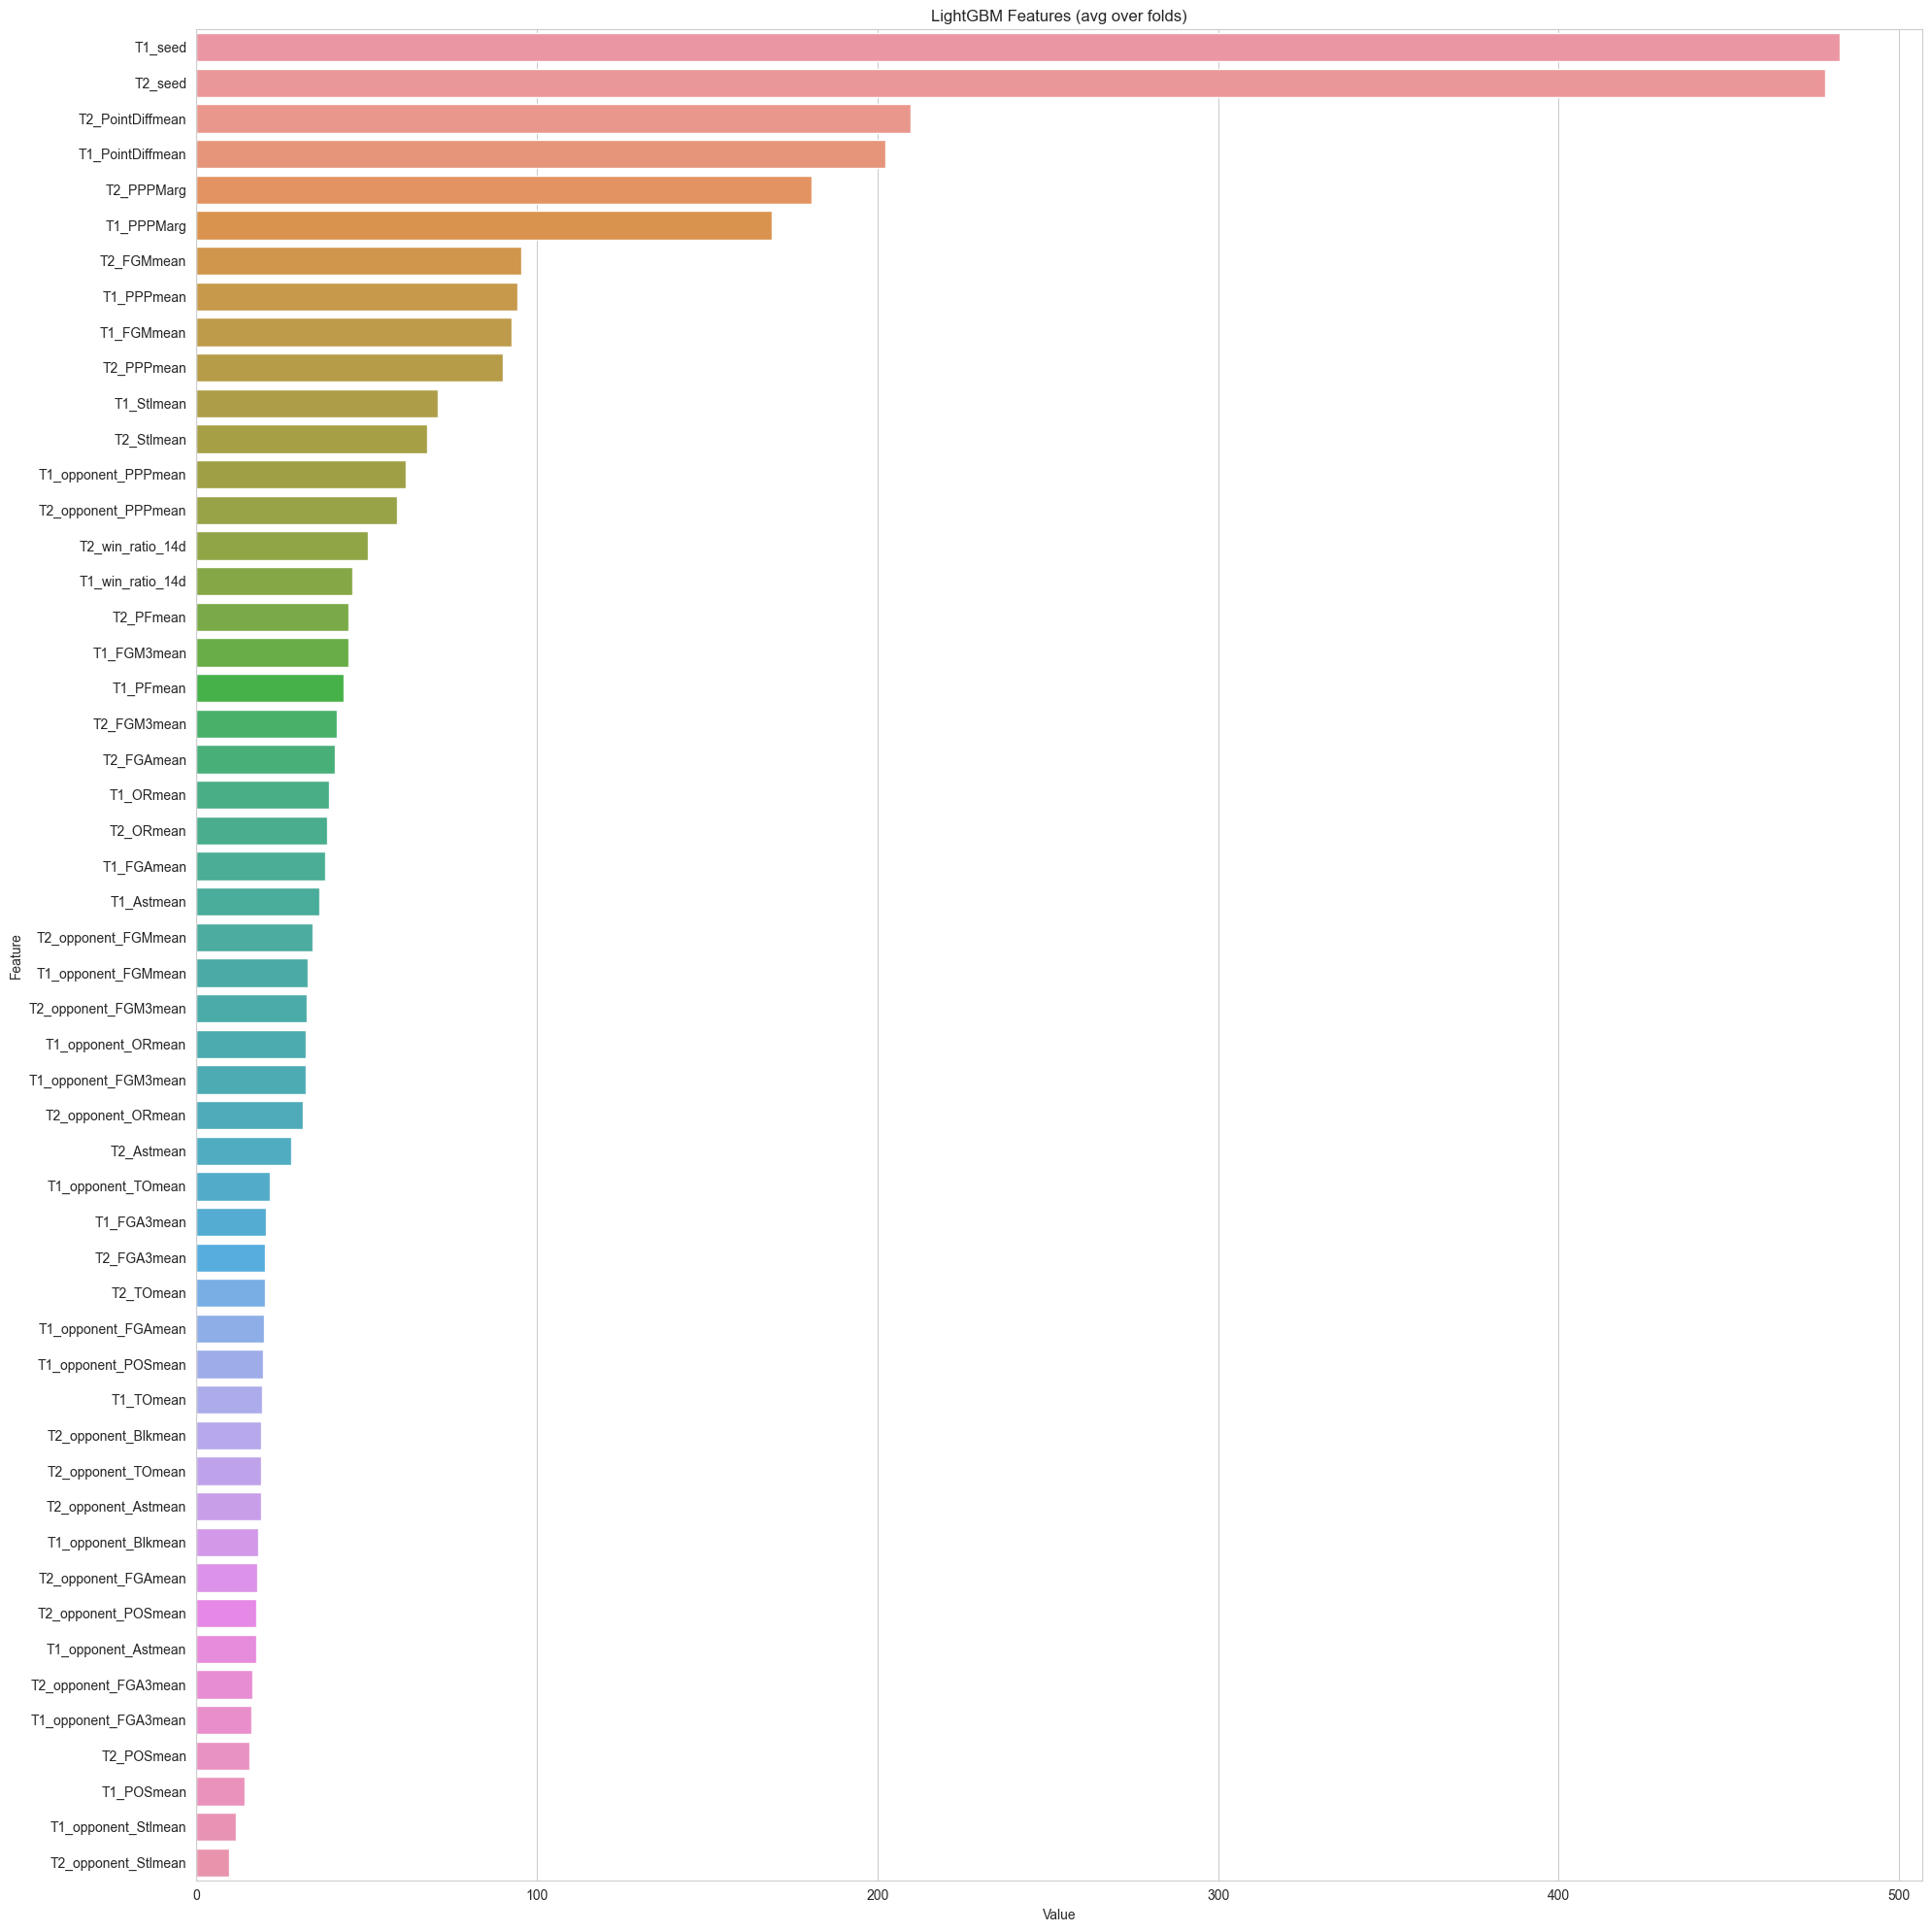

CPU times: total: 3min 58s
Wall time: 19.7 s


In [35]:
%%time
lgbm_cv = []
lgbm_models = []
lgbm_oof_preds = []

feature_importances = np.zeros(X.shape[1])
print(repeat_cv)
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        X_trn, y_trn = X[train_index], y[train_index]
        X_val, y_val = X[val_index], y[val_index]

        clf = LGBMClassifier(n_estimators=500,max_depth=3,learning_rate=0.008462495018311802, num_leaves=100,
                          subsample=0.7,colsample_bytree=0.5).fit(X_trn, y_trn)
        
        feature_importances += clf.feature_importances_/(repeat_cv*kfold.n_splits)
        
        lgbm_models.append(clf)
        
        preds[val_index] = clf.predict_proba(X_val)[:,1]
        
        preds[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 0.95
        preds[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 0.90
        preds[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.05
        preds[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.10
        
    lgbm_oof_preds.append(preds)   

    print(f"brier_score_loss of cvsplit {i}: {brier_score_loss(y,preds)}")
    lgbm_cv.append(brier_score_loss(y,preds))

print("*+"*50)
print("LGBM avg.log loss:",np.mean(lgbm_cv))

sns.distplot(preds)
plt.show()
warnings.simplefilter(action='ignore', category=FutureWarning)
feature_imp = pd.DataFrame(sorted(zip(feature_importances,feat_cols)), columns=['Value','Feature'])
plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

Logistic Regression

Fold repeater 0
brier_score_loss of cvsplit 0: 0.1765599194456555
Fold repeater 1
brier_score_loss of cvsplit 1: 0.1765044515043001
Fold repeater 2
brier_score_loss of cvsplit 2: 0.17680980058899678
Fold repeater 3
brier_score_loss of cvsplit 3: 0.17598059262222698
Fold repeater 4
brier_score_loss of cvsplit 4: 0.17783916531264415
Fold repeater 5
brier_score_loss of cvsplit 5: 0.1764477393773564
Fold repeater 6
brier_score_loss of cvsplit 6: 0.17642631615965543
Fold repeater 7
brier_score_loss of cvsplit 7: 0.17621803639819314
Fold repeater 8
brier_score_loss of cvsplit 8: 0.17695042437670133
Fold repeater 9
brier_score_loss of cvsplit 9: 0.1768845585316713
Fold repeater 10
brier_score_loss of cvsplit 10: 0.1766365599012384
Fold repeater 11
brier_score_loss of cvsplit 11: 0.1770456240786826
Fold repeater 12
brier_score_loss of cvsplit 12: 0.17650601028448637
Fold repeater 13
brier_score_loss of cvsplit 13: 0.1767389217656799
Fold repeater 14
brier_score_loss of cvsplit 14: 0.1765264362

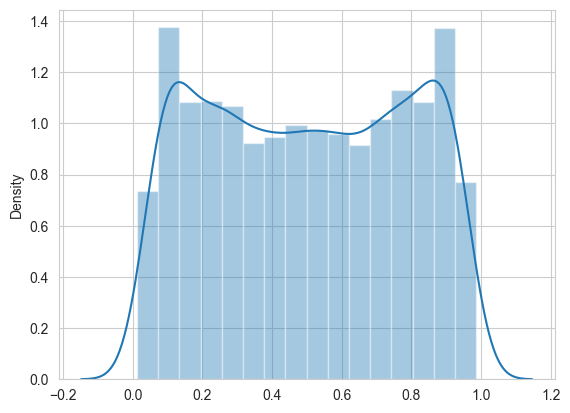

CPU times: total: 4.59 s
Wall time: 7.75 s


In [36]:
%%time
lr_cv = []
lr_models = []
lr_oof_preds = []

for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        X_trn, y_trn = X[train_index], y[train_index]
        X_val, y_val = X[val_index], y[val_index]
        
        clf = LogisticRegression(random_state=0,solver='liblinear').fit(X_trn, y_trn)
        
        lr_models.append(clf)
        
        preds[val_index] = clf.predict_proba(X_val)[:,1]
        
        preds[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 0.95
        preds[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 0.90
        preds[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.05
        preds[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.10
    
    lr_oof_preds.append(preds) 
    
    print(f"brier_score_loss of cvsplit {i}: {brier_score_loss(y,preds)}")
    lr_cv.append(brier_score_loss(y,preds))

print("*+"*50)
print("LR avg.log loss:",np.mean(lr_cv))

sns.distplot(preds)
plt.show()

Ensemble

# Submission

Test Data Prep

In [37]:
sub = pd.read_csv(DATA_PATH+"SampleSubmission2023.csv")
sub["Season"] = sub["ID"].apply(lambda x: x[0:4]).astype(int)
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)

sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'])

sub = pd.merge(sub, season_statistics_2_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, season_statistics_2_T2, on = ['Season', 'T2_TeamID'])

sub = pd.merge(sub, glm_quality_T1, how='left', on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, glm_quality_T2, how='left', on = ['Season', 'T2_TeamID'])

sub = pd.merge(sub, seeds_T1, how='left', on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, seeds_T2, how='left', on = ['Season', 'T2_TeamID'])
sub = pd.merge(sub, last14days_stats_T1, how='left', on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, last14days_stats_T2, how='left', on = ['Season', 'T2_TeamID'])
sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]

sub['T1_quality'] = sub['T1_quality'].astype(np.float32)
sub['T2_quality'] = sub['T2_quality'].astype(np.float32)

sub_copy = sub[features].apply(lambda x: x.replace([np.inf,-np.inf],-999)).fillna(-999)

sub_copy[features_lr] = sub_copy[features_lr].apply(lambda x: x.replace([np.inf,-np.inf],-999)).fillna(-999)

Xsub = sub_copy[features].values
Xsub_2 = sub_copy[features_lr].values

In [38]:
sub_preds_lr = []
sub_preds_lgbm = []

for i in range(repeat_cv): 
    for j in np.arange(5):
        lgbm_pred = lgbm_models[i*5+j].predict_proba(Xsub_2)[:,1]
        lr_pred = lr_models[i*5+j].predict_proba(Xsub_2)[:,1]
        
        sub_preds_lr.append(lr_pred)
        sub_preds_lgbm.append(lgbm_pred)
    
pred_lr = pd.DataFrame(sub_preds_lr).mean(axis=0)
pred_lgbm = pd.DataFrame(sub_preds_lgbm).mean(axis=0)

sub["Pred"] = pred_lgbm*0.5 + pred_lr*0.5

sub.loc[(sub.T1_seed==1) & (sub.T2_seed==16), 'Pred'] = 0.95
sub.loc[(sub.T1_seed==2) & (sub.T2_seed==15), 'Pred'] = 0.90
sub.loc[(sub.T1_seed==16) & (sub.T2_seed==1), 'Pred'] = 0.05
sub.loc[(sub.T1_seed==15) & (sub.T2_seed==2), 'Pred'] = 0.10

sub[['ID','Pred']].to_csv("submission_2.csv", index = None)
sub[['ID','Pred']]

,ID,Pred
0,2023_1101_1102,0.518000
1,2023_1101_1103,0.473488
2,2023_1102_1103,0.464740
3,2023_1101_1104,0.676165
4,2023_1102_1104,0.659814
...,...,...
130678,2023_3472_3477,0.512584
130679,2023_3473_3477,0.740170
130680,2023_3474_3477,0.493706
130681,2023_3475_3477,0.754117


In [39]:
pred_lr_lgbm = sub.copy()
pred_lr_lgbm["Pred"] = pred_lgbm

sub.loc[(sub.T1_seed==1) & (sub.T2_seed==16), 'Pred'] = 0.95
sub.loc[(sub.T1_seed==2) & (sub.T2_seed==15), 'Pred'] = 0.90
sub.loc[(sub.T1_seed==16) & (sub.T2_seed==1), 'Pred'] = 0.05
sub.loc[(sub.T1_seed==15) & (sub.T2_seed==2), 'Pred'] = 0.10

pred_lr_lgbm[['ID','Pred']].to_csv("submission_lgbm.csv", index = None)
pred_lr_lgbm[['ID','Pred']]

,ID,Pred
0,2023_1101_1102,0.541570
1,2023_1101_1103,0.458153
2,2023_1102_1103,0.428851
3,2023_1101_1104,0.352331
4,2023_1102_1104,0.319628
...,...,...
130678,2023_3472_3477,0.512956
130679,2023_3473_3477,0.480340
130680,2023_3474_3477,0.506807
130681,2023_3475_3477,0.508233


In [40]:
pred_lr_sub = sub.copy()
pred_lr_sub["Pred"] = pred_lr

sub.loc[(sub.T1_seed==1) & (sub.T2_seed==16), 'Pred'] = 0.95
sub.loc[(sub.T1_seed==2) & (sub.T2_seed==15), 'Pred'] = 0.90
sub.loc[(sub.T1_seed==16) & (sub.T2_seed==1), 'Pred'] = 0.05
sub.loc[(sub.T1_seed==15) & (sub.T2_seed==2), 'Pred'] = 0.10

pred_lr_sub[['ID','Pred']].to_csv("submission_lr.csv", index = None)
pred_lr_sub[['ID','Pred']]

,ID,Pred
0,2023_1101_1102,0.494430
1,2023_1101_1103,0.488822
2,2023_1102_1103,0.500630
3,2023_1101_1104,1.000000
4,2023_1102_1104,1.000000
...,...,...
130678,2023_3472_3477,0.512212
130679,2023_3473_3477,1.000000
130680,2023_3474_3477,0.480606
130681,2023_3475_3477,1.000000


In [41]:
y_true = pd.read_csv('./2023_04_04_09.15.33  scoring 126 games total.csv')

In [42]:
y_true_filtered = y_true[y_true['Pred'] != -1]

In [43]:
res = y_true_filtered[['ID',"Pred"]]
pred = sub[['ID',"Pred"]]
pred_r= sub[['ID',"Pred"]]     # lr_pred
pred_l = sub[['ID',"Pred"]]    # lgbm_pred
merged = pd.merge(pred, y_true_filtered, on='ID')
merged_lr = pd.merge(pred_r, y_true_filtered, on='ID')
merged_lgbm = pd.merge(pred_l, y_true_filtered, on='ID')
merged.loc[merged['Pred_x'] < 0.5, 'Pred_x'] = 0
merged.loc[merged['Pred_x'] >= 0.5, 'Pred_x'] = 1
merged_lr.loc[merged['Pred_x'] < 0.5, 'Pred_x'] = 0
merged_lr.loc[merged['Pred_x'] >= 0.5, 'Pred_x'] = 1
merged_lgbm.loc[merged['Pred_x'] < 0.5, 'Pred_x'] = 0
merged_lgbm.loc[merged['Pred_x'] >= 0.5, 'Pred_x'] = 1
y_pred, y = merged["Pred_x"].to_numpy(),merged["Pred_y"].to_numpy()
y_pred_lr, y = merged_lr["Pred_x"].to_numpy(),merged_lr["Pred_y"].to_numpy()
y_pred_lgbm, y = merged_lgbm["Pred_x"].to_numpy(),merged_lgbm["Pred_y"].to_numpy()


In [44]:
from sklearn.metrics import classification_report
from IPython.display import display, HTML

report = classification_report(y, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
display(HTML(report_df.to_html()))

,precision,recall,f1-score,support
0,0.734375,0.783333,0.758065,60.000000
1,0.790323,0.742424,0.765625,66.000000
accuracy,0.761905,0.761905,0.761905,0.761905
macro avg,0.762349,0.762879,0.761845,126.000000
weighted avg,0.763681,0.761905,0.762025,126.000000


In [45]:
report_lr = classification_report(y, y_pred_lr, output_dict=True)
report_df_lr = pd.DataFrame(report_lr).transpose()
display(HTML(report_df_lr.to_html()))

,precision,recall,f1-score,support
0,0.734375,0.783333,0.758065,60.000000
1,0.790323,0.742424,0.765625,66.000000
accuracy,0.761905,0.761905,0.761905,0.761905
macro avg,0.762349,0.762879,0.761845,126.000000
weighted avg,0.763681,0.761905,0.762025,126.000000


In [46]:
report_lgbm = classification_report(y, y_pred_lgbm, output_dict=True)
report_df_lgbm = pd.DataFrame(report_lgbm).transpose()
display(HTML(report_df_lgbm.to_html()))

,precision,recall,f1-score,support
0,0.734375,0.783333,0.758065,60.000000
1,0.790323,0.742424,0.765625,66.000000
accuracy,0.761905,0.761905,0.761905,0.761905
macro avg,0.762349,0.762879,0.761845,126.000000
weighted avg,0.763681,0.761905,0.762025,126.000000
